# Fitbit Activity Data - Exploratory Analysis

Wearing a Fitbit while walking, running, or working out collects a variety of health-related data which can provide insight into our general health and activity level. After downloading nearly two years of Fitbit data using the API, cleaning the data and calculating some rolling averages, we are ready to dive into the results.

In [2]:
# function to quietly load packages
load_quietly <- function(package) { 
  suppressWarnings(suppressMessages(library(deparse(substitute(package)), character.only=TRUE))) 
}

options(scipen=999) # turns-off scientific notation

load_quietly(tidyverse)
load_quietly(zoo)
load_quietly(readr)
load_quietly(xts)
theme_set(theme_classic())

fitbit = read.csv('Data/fitbit_v2.csv') %>% select(-X)

# 1. Exploring the Data - Overall

In [3]:
str(fitbit)

'data.frame':	627 obs. of  66 variables:
 $ Date            : Factor w/ 624 levels "2018-02-10","2018-02-11",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Steps           : int  9430 3780 15749 16648 14360 14293 16060 20524 8159 13959 ...
 $ Floors          : int  2 2 37 43 32 34 41 5 5 53 ...
 $ RestHR          : int  59 62 62 60 60 61 61 61 61 58 ...
 $ efficiency      : int  98 93 NA 93 98 94 NA NA NA 98 ...
 $ minutesAsleep   : int  643 615 NA 434 502 511 NA NA NA 498 ...
 $ MinAwake        : int  14 44 NA 33 10 30 NA NA NA 9 ...
 $ restlessCount   : int  6 22 NA 16 6 15 NA NA NA 4 ...
 $ restlessDuration: int  7 32 NA 27 6 25 NA NA NA 5 ...
 $ awakeningsCount : int  8 26 NA 18 7 18 NA NA NA 6 ...
 $ awakeCount      : int  2 4 NA 2 1 3 NA NA NA 2 ...
 $ awakeDuration   : int  7 13 NA 6 4 6 NA NA NA 4 ...
 $ startTime.x     : Factor w/ 253 levels "00:01:00","00:02:00",..: 138 144 NA 167 101 66 NA NA NA 105 ...
 $ endTime         : Factor w/ 231 levels "02:44:00","02:58:30",..: 192 199 NA 46 52 52

As you can see, there are a substantial number of variables available to parse! Narrowing this down to core data on activity and sleep for all days, including running; and limiting these to numeric variables, gives a list of 11.

* Steps
* Floors
* Resting Heart Rate
* Average Heart Rate
* Minutes Awake (during the night)
* Hours Asleep
* Exercise Time (total time duration of run)
* Distance (in miles)
* Pace ()
* Elevation Gain (in feet)
* vo2Max (estimated VO2 Max, calculated by Fitbit)

Let's take a quick glance at the scatterplots, histograms, and correlations between these variables.

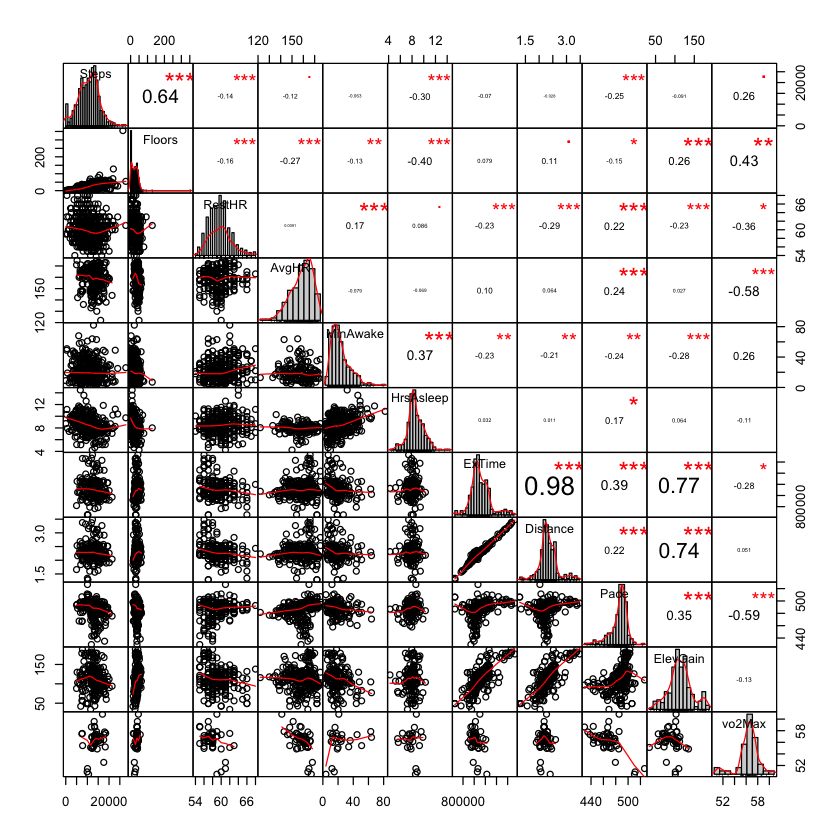

In [4]:
load_quietly(PerformanceAnalytics)
fitbit %>%
  select(Steps,Floors,RestHR,AvgHR,MinAwake,HrsAsleep,ExTime,Distance,Pace,ElevGain,vo2Max) -> cordata
chart.Correlation(cordata, histogram=TRUE, pch=19)

Most of the variables appear normally distributed, or skewed to a single side, with floors being the clear exception. A few times I hiked up a mountain while wearing the Fitbit, creating a few outliers where I climbed far more floors than typical. 

Some of the strongest positive relationships appear among variables which are logically related. Time spent exercising and distance covered have a strong positive relationship (.98), along with elevation gain and time (.77), elevation gain and distance (.74), and steps walked with floors climbed (.64). 

The strong negative relationships are also straightforward, with VO2Max negatively related to both pace (-.59) and average heart rate (-.58). As VO2Max increases (one becomes in better shape) one should be able to cover ground at a faster pace (lower) and have a lower average heart rate.

These correlations are a bit easier to read in a more traditional correlation matrix, found below.

In [5]:
fitbit %>%
  select(Steps,Floors,RestHR,AvgHR,MinAwake,HrsAsleep,ExTime,Distance,Pace,ElevGain,vo2Max) -> cordata
mcor = round(cor(cordata, use="complete.obs"),2) 
upper = mcor
upper[upper.tri(mcor)] <- ""
upper = as.data.frame(upper)
upper

,Steps,Floors,RestHR,AvgHR,MinAwake,HrsAsleep,ExTime,Distance,Pace,ElevGain,vo2Max
Steps,1,,,,,,,,,,
Floors,0.77,1,,,,,,,,,
RestHR,-0.45,-0.62,1,,,,,,,,
AvgHR,-0.23,-0.12,0.02,1,,,,,,,
MinAwake,-0.08,0.12,-0.05,-0.34,1,,,,,,
HrsAsleep,-0.3,-0.32,0.32,-0.35,0.42,1,,,,,
ExTime,0,0.19,-0.06,0.06,-0.06,0.31,1,,,,
Distance,0.14,0.35,-0.25,-0.08,0.03,0.19,0.91,1,,,
Pace,-0.3,-0.25,0.36,0.32,-0.2,0.37,0.5,0.1,1,,
ElevGain,0.24,0.46,-0.2,0.1,-0.05,0.15,0.73,0.62,0.47,1,


Looking at some additional descriptive statistics (number of observations, mean, median, standard deviation, maximum value) for the numeric variables reveals more useful information about our data. 

First, we can get an idea of the total number of days for which we have data (627) and a quick glance reveals the sleep data is missing for a number of days (394/627 = 37% missing data) and even fewer days contain running data (240/627 = 62% missing data).

In [6]:
load_quietly(psych)
numeric = select_if(fitbit, is.numeric)
num = describe(numeric) %>% select(n,mean,median,sd,max)
num

,n,mean,median,sd,max
Steps,627,10623.23923445,10921.00000000,4655.541469130,27763.00000000
Floors,627,24.00478469,23.00000000,21.881724823,355.00000000
RestHR,604,59.83112583,60.00000000,2.628071080,68.00000000
efficiency,394,96.04060914,96.00000000,2.058526767,99.00000000
minutesAsleep,394,509.91624365,497.00000000,82.990760025,869.00000000
MinAwake,394,21.27157360,18.00000000,12.673221314,82.00000000
restlessCount,394,10.47715736,10.00000000,4.703497269,27.00000000
restlessDuration,394,16.40862944,14.00000000,9.390755383,57.00000000
awakeningsCount,394,12.30456853,11.00000000,5.647727318,34.00000000
awakeCount,394,1.82741117,2.00000000,1.350020224,7.00000000


# 2. Step Data

I'll look at daily, weekly, and monthly levels to see if there are any obvious patterns in the data.

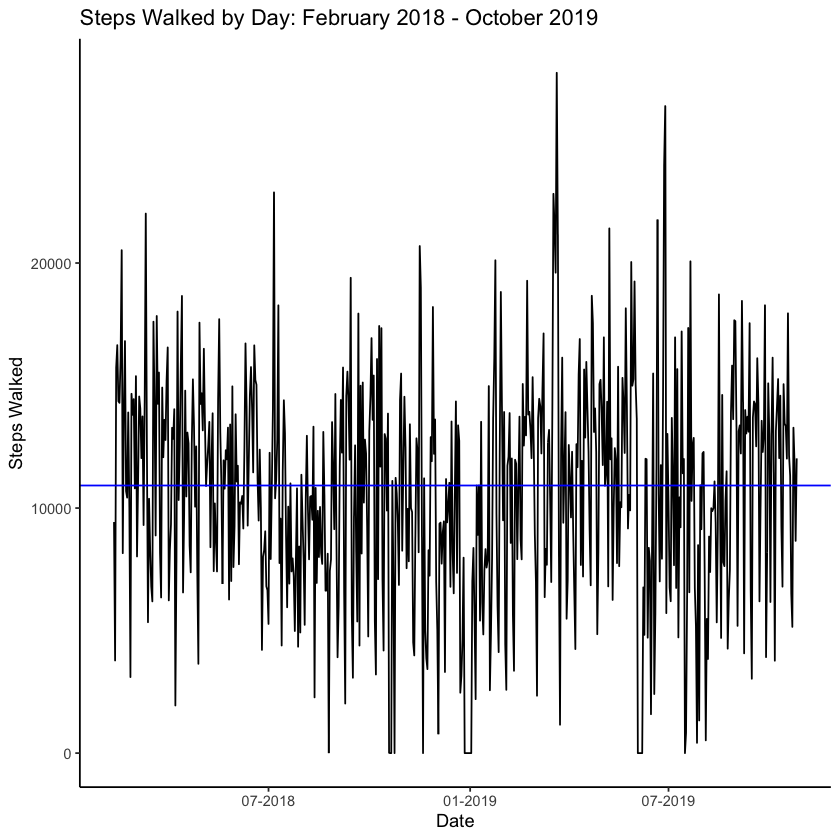

In [7]:
load_quietly(scales)
fitbit %>%
    select(Date, Steps) %>%
    drop_na() %>%
    ggplot(., aes(x = as.Date(Date), y = Steps)) +
        geom_line() +
        geom_hline(yintercept = median(fitbit$Steps, na.rm=T), color="blue") +
        labs(title="Steps Walked by Day: February 2018 - October 2019", y="Steps Walked", x="Date") +
        scale_x_date(labels = date_format("%m-%Y"))

At the daily level, trends are almost impossible to decipher, but it is useful to see the great variation I have had in my steps.

Let's calculate, then examine, weekly averages (removing any zeros - days the Fitbit battery was dead or I forgot to wear it).

In [8]:
# calculate weekly averages, removing empty data
fitbit %>% group_by(Week) %>% 
  summarise(steps_avg = mean(Steps, na.rm=T),
            floors_avg = mean(Floors, na.rm=T),
            HR_avg = mean(RestHR, na.rm=T),
            steps_sum = sum(Steps),
            floors_sum = sum(Floors)) %>%
  add_tally() -> weekly_data
tail(weekly_data)

`summarise()` ungrouping output (override with `.groups` argument)


Week,steps_avg,floors_avg,HR_avg,steps_sum,floors_sum,n
2019-09-15,12611.429,32.71429,58.00000,88280,229,90
2019-09-22,11034.857,22.71429,56.57143,77244,159,90
2019-09-29,11860.000,28.14286,57.57143,83020,197,90
2019-10-06,11750.714,34.28571,57.42857,82255,240,90
2019-10-13,12964.571,30.71429,57.00000,90752,215,90
2019-10-20,9828.143,27.14286,56.71429,68797,190,90


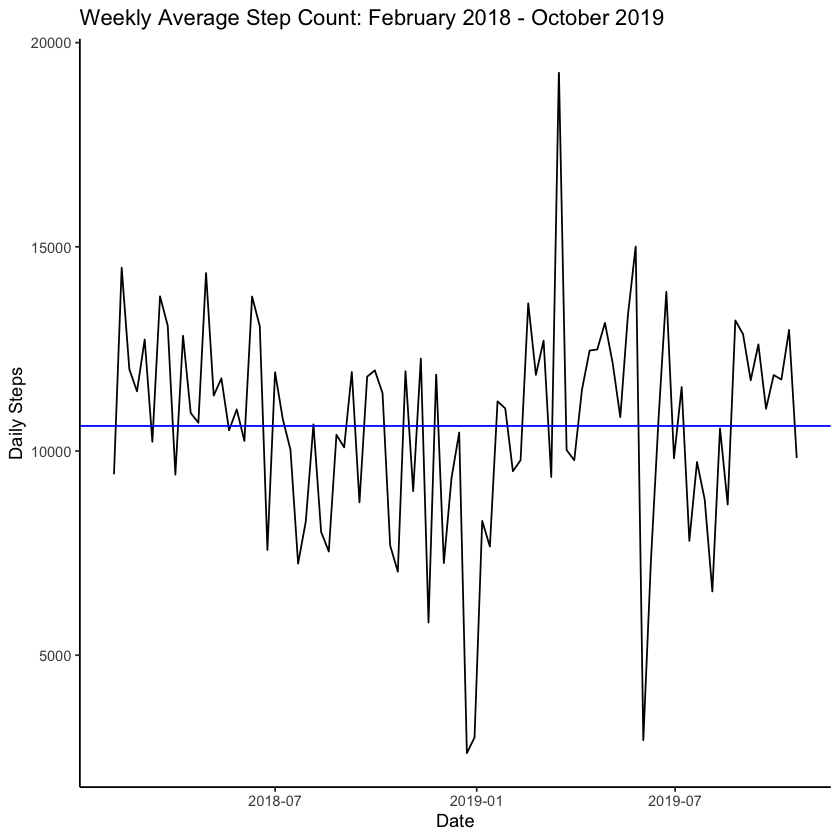

In [9]:
weekly_data %>%
    select(Week, steps_avg) %>%
    drop_na() %>%
    ggplot(., aes(x = as.Date(Week), y = steps_avg)) +
        geom_line() +
        geom_hline(yintercept = mean(weekly_data$steps_avg, na.rm=T), color="blue") +
        labs(title="Weekly Average Step Count: February 2018 - October 2019", y="Daily Steps", x="Date")

As you can see, aggregating steps to a weekly level removes a decent amount of noise, making it easier to see basic trends and patterns in how many steps I've walked. Can you find the weeks where I wasn't up to my 'usual' activities?

These data are interesting, but it might be easier to see long-term trends at the monthly level. A boxplot of steps walked each month of the year is up next.

In [10]:
# calcuate monthly averages
fitbit %>% group_by(Month, Year) %>% 
  summarise(steps_avg = mean(Steps, na.rm=T),
            floors_avg = mean(Floors, na.rm=T),
            HR_avg = mean(RestHR, na.rm=T),
            steps_sum = sum(Steps),
            floors_sum = sum(Floors)) %>%
  add_tally() %>%
  arrange(Year) -> monthly_data
tail(monthly_data)

`summarise()` regrouping output by 'Month' (override with `.groups` argument)


Month,Year,steps_avg,floors_avg,HR_avg,steps_sum,floors_sum,n
July,2019,9332.000,15.61290,63.11111,289292,484,2
June,2019,9099.167,26.36667,60.04348,272975,791,2
March,2019,12335.968,28.29032,60.48387,382415,877,2
May,2019,12831.581,29.83871,58.54839,397779,925,2
October,2019,11598.462,30.19231,57.11538,301560,785,2
September,2019,12031.200,28.70000,57.60000,360936,861,2


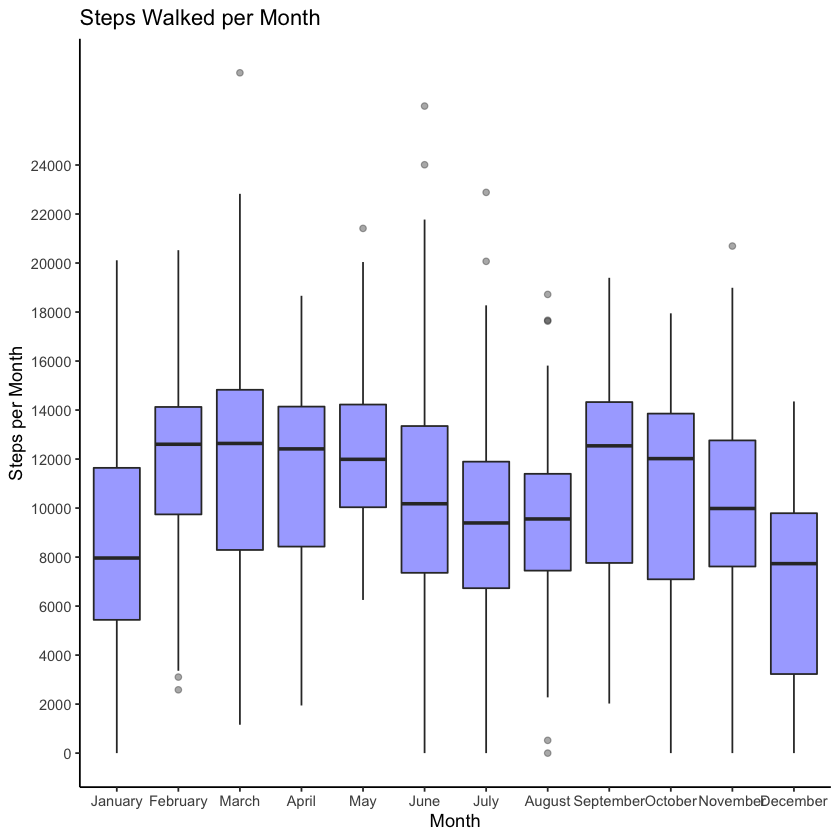

In [11]:
load_quietly(lubridate)
fitbit$Date <- as.Date(fitbit$Date, "%Y-%m-%d") # must first turn Date to Date
fitbit$Month <- format(fitbit$Date,"%B") # create a month category
fitbit$Month <- as.factor(fitbit$Month)

fitbit$Month = ordered(fitbit$Month, levels=c('January','February','March','April','May',
                                            'June','July','August','September','October','November','December'))

ggplot(fitbit, aes(x = Month, y = Steps)) +
  geom_boxplot(fill='blue', alpha=0.4) +
  scale_x_discrete(name = "Month") +
  scale_y_continuous(name = "Steps per Month", breaks = seq(0, 25000, 2000)) +
  ggtitle("Steps Walked per Month")

I'm currently in graduate school, which should be quite evident from this chart. Months when I do not walk to work (summer and winter) clearly show lower median steps.

What about day of the week? Since going to work appears to have an impact on steps at the monthly level, perhaps it also does at the daily level.

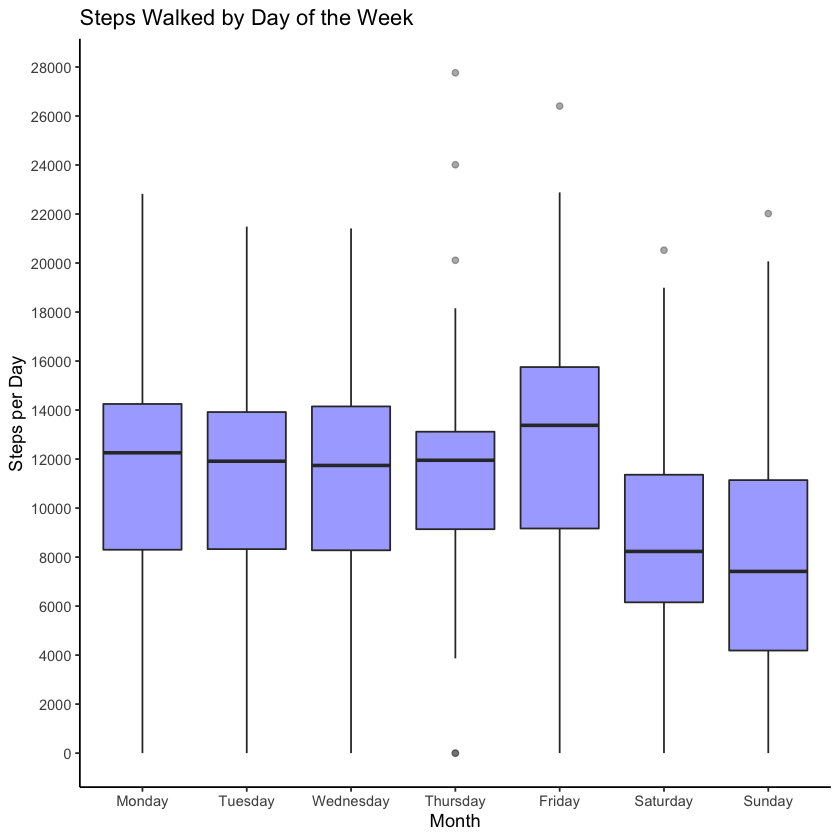

In [12]:
fitbit$Day <- format(fitbit$Date,"%A") # create a day category
fitbit$Day <- as.factor(fitbit$Day)

fitbit$Day = ordered(fitbit$Day, levels=c('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))

ggplot(fitbit, aes(x = Day, y = Steps)) +
  geom_boxplot(fill='blue', alpha=0.4) +
  scale_x_discrete(name = "Month") +
  scale_y_continuous(name = "Steps per Day", breaks = seq(0, 30000, 2000)) +
  ggtitle("Steps Walked by Day of the Week")

Well, look at that. Saturday and Sunday are not fitness days for me, but apparently I'm all about Fitness Fridays.

# 3. Sleep Data

When does my sleep start? When do I typically wake up?

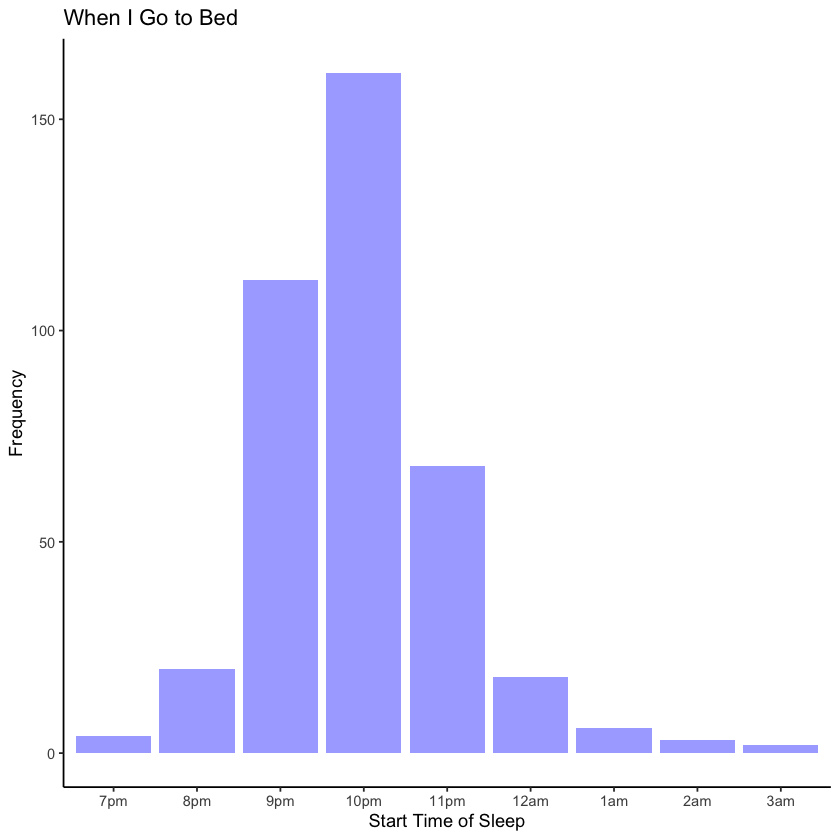

In [13]:
fitbit$startHour <- factor(fitbit$startHour, levels = c("7pm", "8pm", "9pm", "10pm","11pm","12am","1am","2am","3am"))

fitbit %>%
  select(startHour) %>%
  drop_na() %>%
  ggplot(., aes(x=startHour, stat = "identity")) + 
    geom_bar(fill='blue', alpha=0.4) +
    labs(title="When I Go to Bed", y="Frequency", x="Start Time of Sleep")

There are some fun late nights, and some nights when I'm just too exhausted to stay awake, but most nights I seem to drift off at around the same time. Score one for consistency.

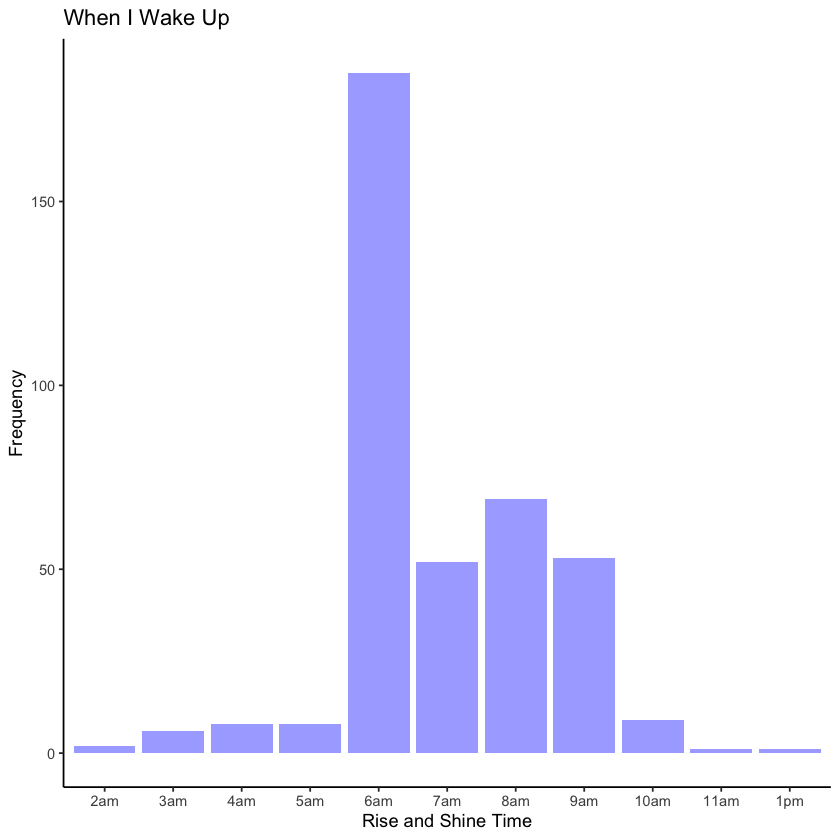

In [14]:
fitbit$endHour <- factor(fitbit$endHour, levels = c("2am","3am","4am","5am","6am","7am","8am","9am","10am","11am","1pm"))

fitbit %>%
  select(endHour) %>%
  drop_na() %>%
  ggplot(., aes(x=endHour, stat = "identity")) + 
    geom_bar(fill='blue', alpha=0.4) +
    labs(title="When I Wake Up", y="Frequency", x="Rise and Shine Time")

About the same can be said for waking up, though the data are less normally distributed here (I blame my alarm clock going off just after 6 each morning).

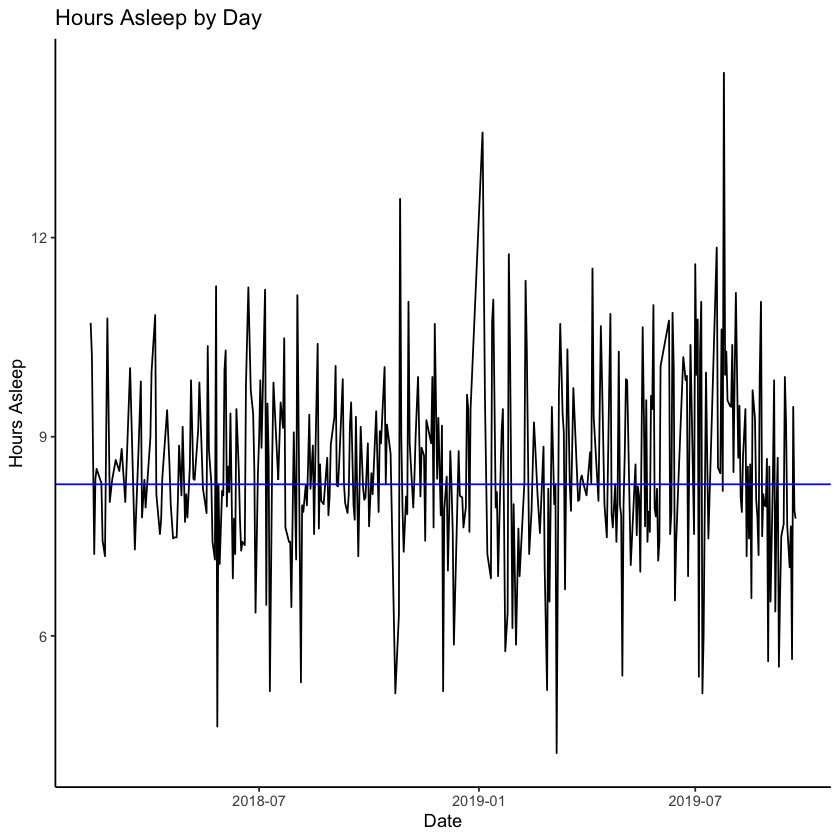

In [15]:
fitbit %>%
    select(HrsAsleep, Date) %>%
    drop_na() %>%
    ggplot(., aes(x = Date, y = HrsAsleep)) +
        geom_line() +
        geom_hline(yintercept = median(fitbit$HrsAsleep, na.rm=T), color="blue") +
        labs(title="Hours Asleep by Day", y="Hours Asleep", x="Date")

There is significant variation in the amount of sleep I get each night, with a median near 8 hours.

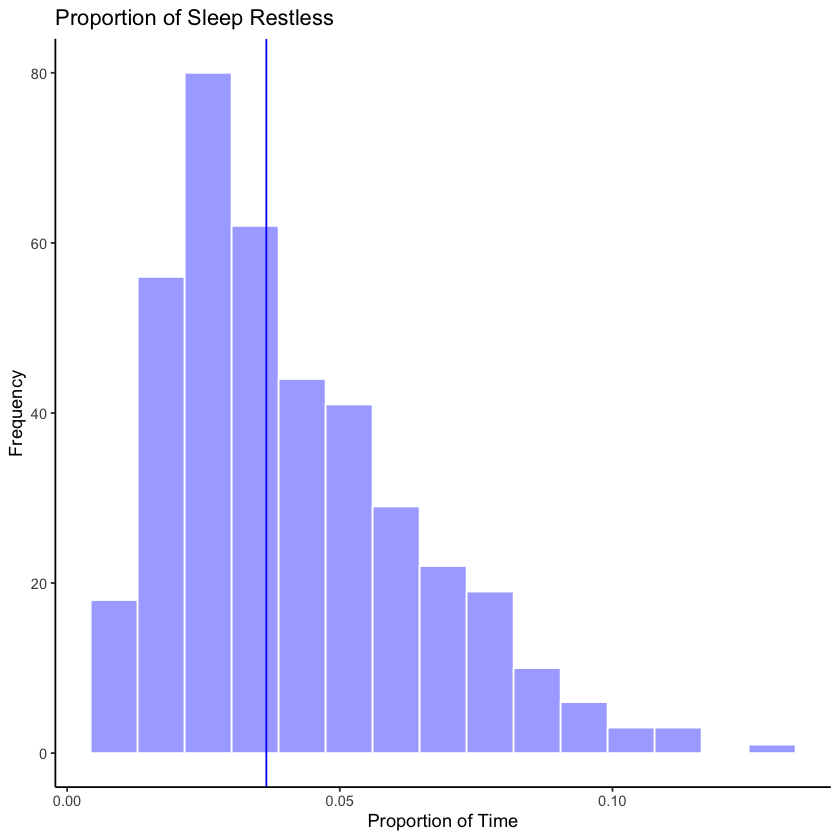

In [16]:
fitbit %>%
  select(notAsleepPct) %>%
  drop_na() %>%
  ggplot(., aes(x=notAsleepPct)) + 
    geom_histogram(fill='blue', alpha=0.4, bins=15, color="white") +
    geom_vline(xintercept = median(fitbit$notAsleepPct, na.rm=T), color="blue") +
    labs(title="Proportion of Sleep Restless", y="Frequency", x="Proportion of Time")

While I don't have the data from others to compare, it appears as if I am a relatively resftul sleeper. Most nights I am only restless for around 4% of the time (median).

# 4. Heart Data

While Fitbit provides minute-by-minute heart rate data, I am more interested in aggregate measures of my fitness, such as my resting heart rate. I wonder what it hovers around and if it is stable across time?

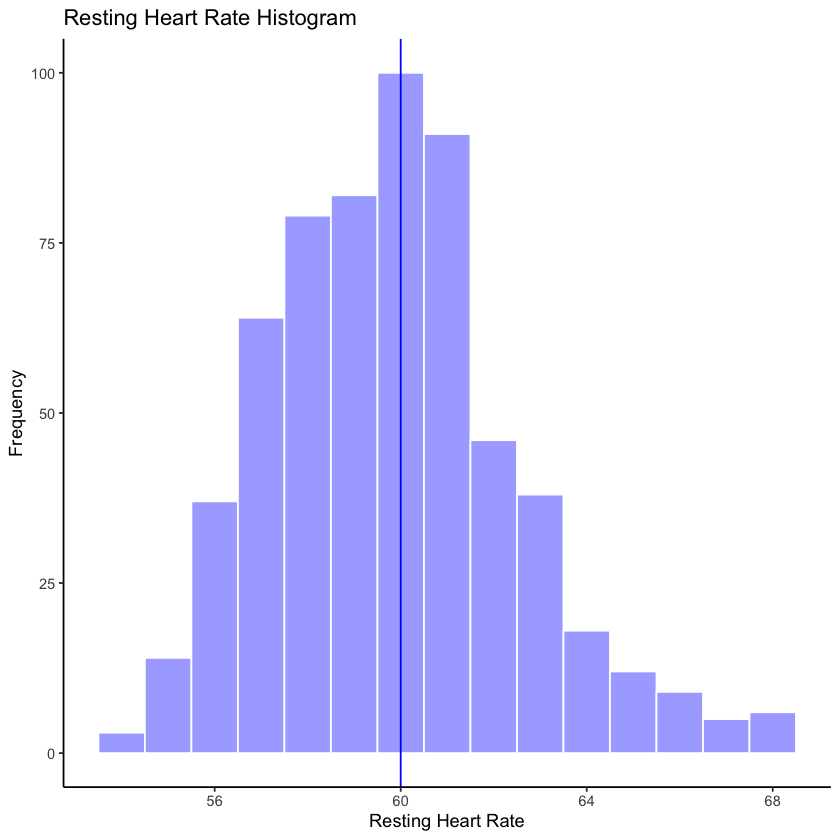

In [17]:
fitbit %>%
  select(RestHR) %>%
  drop_na() %>%
  ggplot(., aes(x=RestHR)) + 
    geom_histogram(fill='blue', alpha=0.4, bins=15, color="white") +
    geom_vline(xintercept = median(fitbit$RestHR, na.rm=T), color="blue") +
    labs(title="Resting Heart Rate Histogram", y="Frequency", x="Resting Heart Rate")

My resting heart rate appears to hover around 60 beats per minute over this time period and is mostly normally distributed.

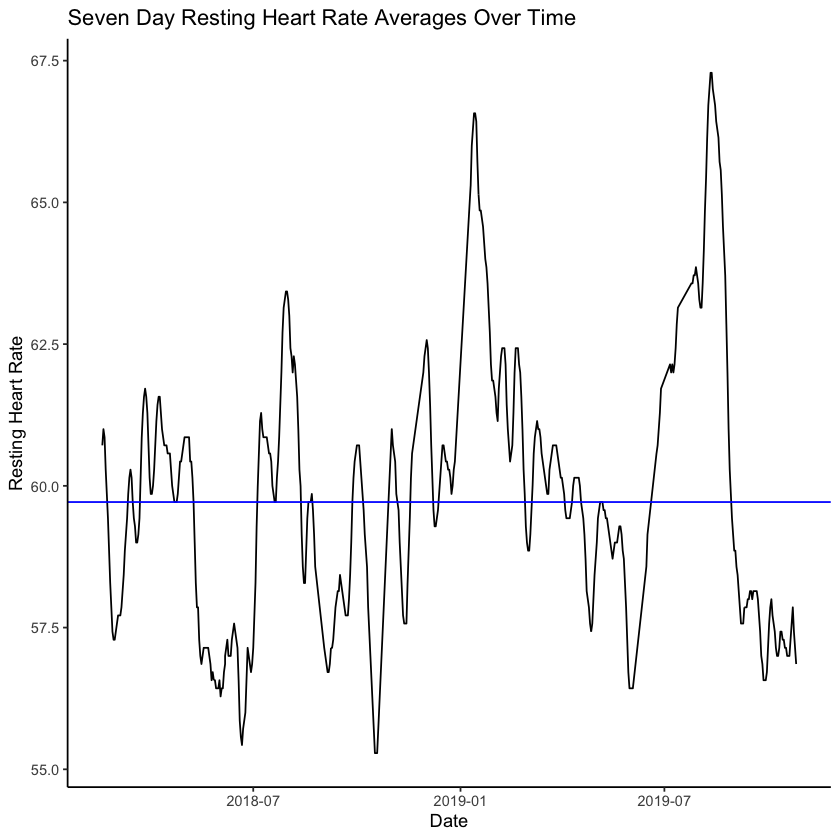

In [18]:
fitbit %>%
    select(HR7dayAvg, Date) %>%
    drop_na() %>%
    ggplot(., aes(x = Date, y = HR7dayAvg)) +
        geom_line() +
        geom_hline(yintercept = median(fitbit$HR7dayAvg, na.rm=T), color="blue") +
        labs(title="Seven Day Resting Heart Rate Averages Over Time", y="Resting Heart Rate", x="Date")

While the histogram paints a picture of a nearly steady resting heart rate, looking at the seven day averages over time my fitness levels appear to fluctuate. Near the end of semesters, after maintaining a steady running regimin, I experience my lowest resting heart rates. Unfortunately, the change in my schedule lowers the amount of time I devote to running (and walking to work), which can be seen with the rising resting heart rates over winter and spring seasons.

# Conclusions

After exploring the data a bit, with a focus on fitness measures, it appears that my level of fitness very much depends upon the time of year, or day of week (steps on the weekends). In the next phase I will examine these patterns some more, with a focus on trying to predict how active I am, and how fast I will run, using historical data.